This time we will be implementing an RNN model.

Time series forcasting is an important topic in Machine Learning.\
In this, we will are given the data for sunspots from jan 1749 to dec 1983.\
we will be dividing this data in to two parts, one for training our model and second for testing our model.\
In time series forcasting, we will have to take continuous data and not randomized data, because we have to predict on the basis of given past data.

In [35]:
import pandas as pd
import numpy as np

We will have to take the data from the url given.

You have to implement the get_train_test function and return train_data and test_data, scaled in the range [0,1]

To scale the data, read on MinMaxScalar class in sklearn.preprocessing

Testing data should be the first 80 percent values and rest should be testing data. Also, convert the index of the data to datetime

In [65]:
from sklearn.preprocessing import MinMaxScaler
def get_train_test(url):
    data = pd.read_csv(url)
    data['Month'] = pd.to_datetime(data['Month'])
    data.set_index('Month', inplace=True)
    data.sort_index(inplace=True)
    
    train_len = int(0.8 * data.shape[0])
    train, test = data.iloc[0:train_len], data.iloc[train_len:data.shape[0]]
    
    scaler = MinMaxScaler(feature_range=(0,1))
    train_scaled, test_scaled = np.array(scaler.fit_transform(train)).reshape(-1), np.array(scaler.fit_transform(test)).reshape(-1)
    return train_scaled, test_scaled

Now we will take the data from our implemented function :)

In [66]:
sunspots_url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-sunspots.csv'
train_data, test_data = get_train_test(sunspots_url)

X_train = train_data[:-1]
y_train = train_data[1:]

X_test = test_data[:-1]
y_test = test_data[1:]

Now let's make the model for our computations.

The model will consist of a layer of RNN of 64 nodes followed by a layer of Feed Forward Neural Network of one output node.

For compiling the node, we will use mean squared error as loss and mean absolute error as metric. We will not use accuracy as the metric.

In [87]:
# ReLU and Sigmoid function
def ReLU(Z):
    return np.where(Z>0, Z, 0)

def Sigmoid(Z):
    return 1/(1 + np.exp(-Z))

In [ ]:
class RNN:
    def __init__(self, n_nodes=64, learning_rate = 0.01):
        self.n_nodes = n_nodes
        self.lr = learning_rate
        
        # Initialise weights and biases
        self.w = np.random.rand()
        self.u = np.random.rand()
        self.b1 = 0
        self.v = np.random.rand()
        self.b2 = 0
        
        # Entities in the Network
        self.S0 = None  #the input short term memory in a hidden unit
        self.Z1 = None
        self.S1 = None  #the output short term memory in a hidden unit
        self.Z2 = None
        self.Y_pred = None
        
        # Initialising gradients
        self.dZ2 = None
        self.dv = None
        self.db2 = None
        self.dS1 = None
        self.dZ1 = None
        self.dw = None
        self.du = None
        self.db1 = None
        
    # Forward propagation
    def forward_propagation(self,X):
        m = X.shape[1]     # Number of data sequences
        
        # initialise short term memory
        self.S0 = np.zeros(m)
        
        #loop over n_nodes nodes
        for i in range(self.n_nodes):
            self.x = X[i]
            
            if i != 0:
                self.S0 = self.S1
            
            self.Z1 = self.w*self.S0 + self.u*self.x + self.b1
            self.S1 = ReLU(self.Z1)
            
        self.Z2 = self.v*self.S1 + self.b2
        self.Y_pred = Sigmoid(self.Z2)
        
    
    # Cost function
    def cost(self,y):
        m = len(self.x)
        return (1/m) * np.sum(np.power(self.Y_pred - y,2))
        
    
    #Backward Propagation
    def backward_propagation(self,X,y):
        m = X.shape[1]
        
        self.dZ2 = 2 * (self.Y_pred - y) * (1 - self.Y_pred) * self.Y_pred
        self.dv = (1/m) * np.matmul(self.dZ2, self.S1.T)
        self.db2 = (1/m) * np.sum(self.dZ2)
        self.dS1 = self.v * self.dZ2
        self.dZ1 = self.dS1 * np.where(self.Z1>0, 1, 0)
        self.dw = (1/m) * np.matmul(self.dZ1, self.S0.T)
        self.du = (1/m) * np.matmul(self.dZ1, self.x)
        self.db1 = (1/m) * np.sum(self.dZ1)
    
    
    #Update parameters
    def update_params(self):
        self.w = self.w - self.lr * self.dw
        self.u = self.u - self.lr * self.du
        self.b1 = self.b1 - self.lr * self.db1
        self.v = self.v - self.lr * self.dv
        self.b2 = self.b2 - self.lr * self.db2
        
        
    # gradient descent
    def gradient_descent(self, input_seq, output_seq, iters=1000):
        batch_size = self.n_nodes
        batches = [input_seq[i:i+batch_size] for i in range(len(input_seq) - batch_size + 1)]
        X = np.array(batches).T
        y = output_seq[self.n_nodes - 1:]
        
        m = X.shape[1]
        for i in range(iters):
            self.forward_propagation(X)
            self.backward_propagation(X,y)
            self.update_params()
            
            if i%(iters/10) == 0:
                print(f"The value of the cost function after {i} iterations is {self.cost(y)}")
            
    
    # Getting the predictions
    def get_predictions(self,X):
        n = len(X)
        Y_pred = []
        s = 0
        for i in range(n):
            x = X[i]
            
            z1 = self.w * s + self.u * x + self.b1
            s = ReLU(z1)
            y_pred = Sigmoid(self.v * s + self.b2)
            Y_pred.append(y_pred)
            # print(x, z1, s, y_pred)
        
        return Y_pred

In [132]:
# train the model on the X_train dataset

model = RNN(n_nodes=64, learning_rate=0.01)
model.gradient_descent(input_seq=X_train, output_seq=y_train, iters=100000)

The value of the cost function after 0 iterations is 0.13590244664721124
The value of the cost function after 10000 iterations is 0.007965146823668343
The value of the cost function after 20000 iterations is 0.006463666276141246
The value of the cost function after 30000 iterations is 0.00598867976257146
The value of the cost function after 40000 iterations is 0.0057167598198858355
The value of the cost function after 50000 iterations is 0.005538348584718357
The value of the cost function after 60000 iterations is 0.005411282040014267
The value of the cost function after 70000 iterations is 0.005318188104681138
The value of the cost function after 80000 iterations is 0.005248440412895816
The value of the cost function after 90000 iterations is 0.005195096002641574


In [135]:
# predict the values for training and testing data
train_predict = model.get_predictions(X_train)
test_predict = model.get_predictions(X_test)

print(train_predict[100:120])
print(test_predict[100:120])

[0.12445658721250845, 0.11183389619557232, 0.1134737687702755, 0.13703090179334854, 0.1429837156436837, 0.14006465425807152, 0.17087457036591513, 0.15843652175464149, 0.15490417757467367, 0.16773246589501314, 0.17312686124606186, 0.2046752891392785, 0.1938300291327927, 0.1853786685094989, 0.17890295198887787, 0.16892075629933914, 0.18955091103300442, 0.17434829186680406, 0.17078032150929381, 0.1684970427817272]
[0.11422638838715003, 0.12230212803979647, 0.13312829052801284, 0.1264091393223454, 0.12947265014894435, 0.1626031000399202, 0.1633680971281297, 0.1460070506147449, 0.15391777251490713, 0.20091194853377303, 0.2242333106525138, 0.23915447870921616, 0.2620377812855169, 0.26115032876125976, 0.32529282073134846, 0.35566299937491175, 0.3542480952305333, 0.36669096980775573, 0.4125070653582491, 0.4393147675397216]


Printing the results

Train RMSE: 0.072 RMSE
Test RMSE: 0.085 RMSE


Text(0.5, 1.0, 'Actual and Predicted Values. The Red Line Separates The Training And Test Examples')

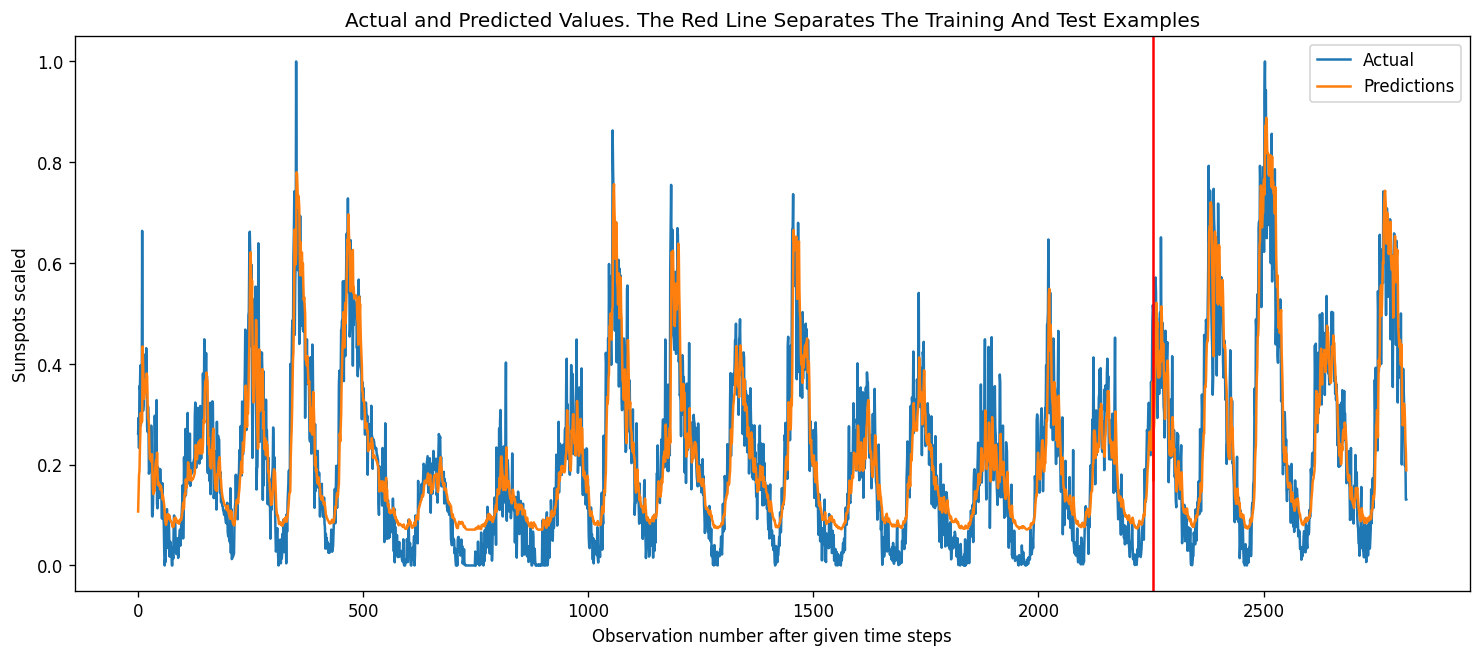

In [134]:
import math
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

   
train_rmse = math.sqrt(mean_squared_error(y_train, train_predict))
test_rmse = math.sqrt(mean_squared_error(y_test, test_predict))
# Print RMSE
print('Train RMSE: %.3f RMSE' % (train_rmse))
print('Test RMSE: %.3f RMSE' % (test_rmse))    

actual = np.append(y_train, y_test)
predictions = np.append(train_predict, test_predict)
rows = len(actual)
plt.figure(figsize=(15, 6), dpi=120)
plt.plot(range(rows), actual)
plt.plot(range(rows), predictions)
plt.axvline(x=len(y_train), color='r')
plt.legend(['Actual', 'Predictions'])
plt.xlabel('Observation number after given time steps')
plt.ylabel('Sunspots scaled')
plt.title('Actual and Predicted Values. The Red Line Separates The Training And Test Examples')